In [117]:
import pandas as pd
import numpy as np

# Plotting and correlation
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Model
from sklearn.model_selection import train_test_split
from scipy.stats import linregress
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import svm
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import RidgeCV

# Feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression

import warnings
warnings.filterwarnings('ignore')

Goal: predict monthly emissions based on demand and vehicle distribution

**Load data**

In [108]:
# monthly CA electricity demand (MWh)

df1 = pd.read_csv('data/cleaned/monthly_demand.csv')
df1.rename(columns={'Unnamed: 0':'date'},inplace=True)
df1.head()

,date,demand
0,202211,18098856
1,202210,22583054
2,202209,27240453
3,202208,29002852
4,202207,26935101


In [109]:
# monthly CA CO2 emissions (mTCO2)

df2 = pd.read_csv('data/cleaned/monthly_emissions.csv')
df2.rename(columns={'Unnamed: 0':'date'},inplace=True)
df2.head()

,date,emissions
0,201401,5615497.820
1,201402,5022762.297
2,201403,5289480.524
3,201404,4812433.460
4,201405,5331965.630


In [110]:
# monthly estimated CA vehicle distribution

df3 = pd.read_csv('data/cleaned/monthly_vehicles.csv')
df3 = df3.drop(columns=['Unnamed: 0','date_idx','total'])
df3.head()

,date,electric,plug-in hybrid electric,fuel cell,diesel,flex fuel,gasoline,gasoline hybrid,natural gas fuel,propane
0,202112,522445,305315,10127,590216,1208970,25998618,1298275,8461,90
1,202111,505951,300973,9877,599395,1203600,25917181,1285769,8395,157
2,202110,490400,297256,9627,608574,1198231,25835745,1275167,8330,224
3,202109,476248,292462,9377,617753,1192861,25754308,1263823,8264,291
4,202108,462251,289169,9127,626932,1187492,25672872,1253083,8199,359


In [111]:
# merged dataframe

df = df1.merge(df2, left_on='date', right_on='date')
df = df.dropna()

df = df.merge(df3, left_on='date', right_on='date')
df = df.dropna()

df.head()

,date,demand,emissions,electric,plug-in hybrid electric,fuel cell,diesel,flex fuel,gasoline,gasoline hybrid,natural gas fuel,propane
0,202112,22418337,4959996.71,522445,305315,10127,590216,1208970,25998618,1298275,8461,90
1,202111,20251317,4365100.13,505951,300973,9877,599395,1203600,25917181,1285769,8395,157
2,202110,21604672,4577134.35,490400,297256,9627,608574,1198231,25835745,1275167,8330,224
3,202109,24859626,5070292.57,476248,292462,9377,617753,1192861,25754308,1263823,8264,291
4,202108,27525448,5607233.68,462251,289169,9127,626932,1187492,25672872,1253083,8199,359


**Correlation**

<AxesSubplot: >

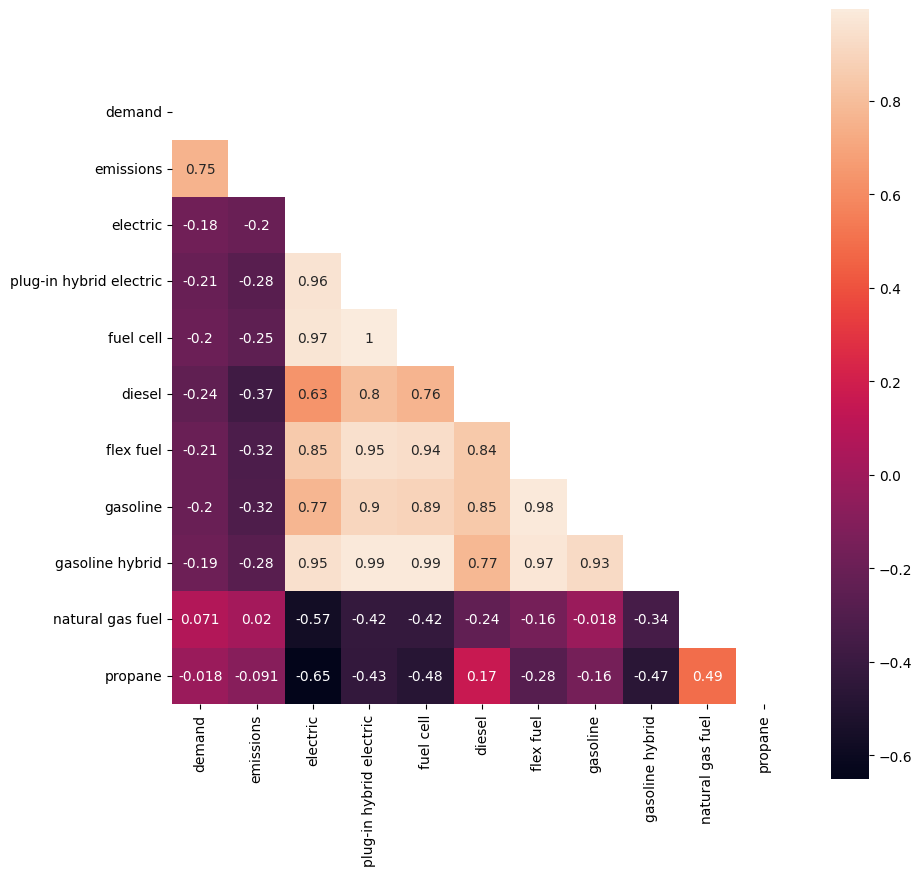

In [112]:
df = df.drop(columns=['date'])
correlation = df.corr(method = 'pearson')
plt.subplots(figsize = (10,10))
masked = np.triu(np.ones_like(correlation, dtype=bool)) 
sns.heatmap(correlation,mask=masked,square = True, annot = True)

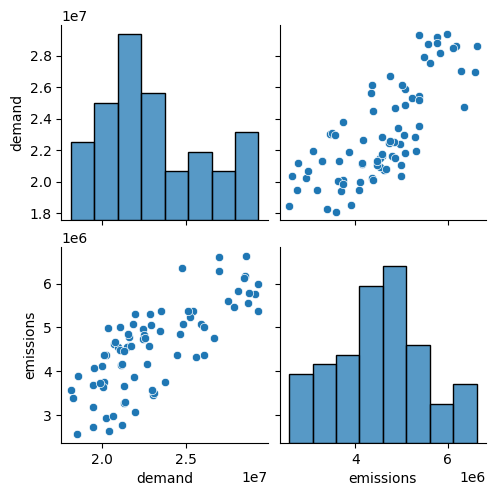

Correlation coefficient: 0.753671530416928
p-value: 1.6841189005888735e-15


In [113]:
ed = df[['demand','emissions']]

sns.pairplot(ed, kind='scatter')
plt.show()

corrcoef = np.corrcoef(df['demand'], df['emissions'])[0,1]
print(f'Correlation coefficient: {corrcoef}')

p_value = linregress(df['demand'], df['emissions']).pvalue
print(f'p-value: {p_value}')

This monthly demand dataset is from a different source than the 5-minute increment demand dataset from 1_initial_analysis.ipynb. We see however that that the measured patterns are similar because there is still a mildly strong positive correlation between demand and emissions

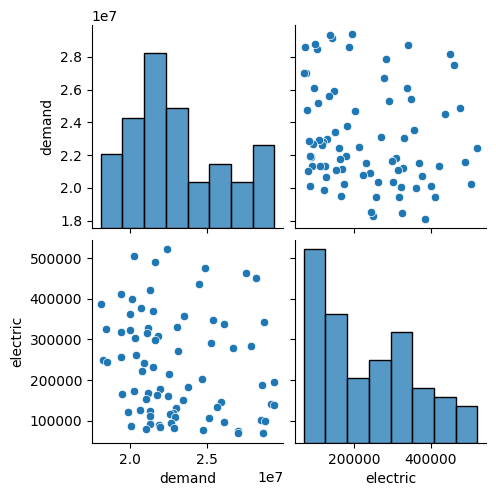

Correlation coefficient: -0.17528748239804787
p-value: 0.12478034307680883


In [114]:
ed = df[['demand','electric']]

sns.pairplot(ed, kind='scatter')
plt.show()

corrcoef = np.corrcoef(df['demand'], df['electric'])[0,1]
print(f'Correlation coefficient: {corrcoef}')

p_value = linregress(df['demand'], df['electric']).pvalue
print(f'p-value: {p_value}')

Unintuitively, there is a weak negative correlation between EV numbers and electricity demand. This is likely because many other factors determine electricity demand at a given moment besides EV charging

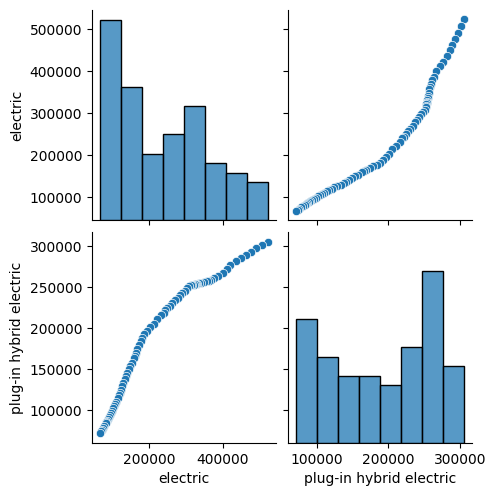

Correlation coefficient: 0.9596962001576311
p-value: 1.2128720368039454e-43


In [115]:
ed = df[['electric','plug-in hybrid electric']]

sns.pairplot(ed, kind='scatter')
plt.show()

corrcoef = np.corrcoef(df['electric'], df['plug-in hybrid electric'])[0,1]
print(f'Correlation coefficient: {corrcoef}')

p_value = linregress(df['electric'], df['plug-in hybrid electric']).pvalue
print(f'p-value: {p_value}')

There is a very strong positive correlation between the number of EVs and the number of plug-in hybrid vehicles. As they are similar in purpose, it seems that their popularity grows at the same rate

**Modeling**

Goal: test out models that predict CA monthly emissions based on vehicle distribution and electricity demand

In [169]:
# Random forest regressor. Input: demand, vehicle distributions; output: emissions

# Best parameters: {'n_estimators': 100, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 7}

X = df.drop(columns=['emissions'])
y = df['emissions']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

distribution = {
       'n_estimators': [2,3,5,10,20,30,50,100,200] ,  
       'max_features': ['log2','sqrt','auto'],
       'max_depth': [3,5,7,9,12] ,
       'min_samples_split': [2,4,6,8,10,15,20,30] ,
       'min_samples_leaf': [1,3,4,6,10,15,17]
       }

random_forest = RandomForestRegressor()
rf_model = RandomizedSearchCV(estimator = random_forest, param_distributions = distribution, n_iter = 10)                
rf_model.fit(X_train,  y_train)

print(f'Input: {list(X.columns)}')
print(f'Best parameters: {rf_model.best_params_}')
print(f'Training data score: {rf_model.score(X_train,  y_train)}')
print(f'Testing data score: {rf_model.score(X_test, y_test)}')

Input: ['demand', 'electric', 'plug-in hybrid electric', 'fuel cell', 'diesel', 'flex fuel', 'gasoline', 'gasoline hybrid', 'natural gas fuel', 'propane']
Best parameters: {'n_estimators': 30, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_depth': 12}
Training data score: 0.8335523529481751
Testing data score: 0.6545732386035069


In [150]:
# Gradient boosting regressor. Input: demand, vehicle distributions; output: emissions

# Best parameters: {'n_estimators': 50, 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 3}

X = df.drop(columns=['emissions'])
y = df['emissions']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

distribution = {
       'n_estimators': [2,3,5,10,20,30,50,100,200] ,  
       'max_features': ['log2','sqrt','auto'],
       'max_depth': [3,5,7,9,12] ,
       'min_samples_split': [2,4,6,8,10,15,20,30] ,
       'min_samples_leaf': [1,3,4,6,10,15,17]
       }

grad_boost = GradientBoostingRegressor()
gb_model = RandomizedSearchCV(estimator = grad_boost, param_distributions = distribution, n_iter = 10)                
gb_model.fit(X_train,  y_train)

print(f'Input: {list(X.columns)}')
print(f'Best parameters: {gb_model.best_params_}')
print(f'Training data score: {gb_model.score(X_train,  y_train)}')
print(f'Testing data score: {gb_model.score(X_test, y_test)}')

Input: ['demand', 'electric', 'plug-in hybrid electric', 'fuel cell', 'diesel', 'flex fuel', 'gasoline', 'gasoline hybrid', 'natural gas fuel', 'propane']
Best parameters: {'n_estimators': 50, 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 3}
Training data score: 0.9097130088092624
Testing data score: 0.7120156533676618


Likely overfitting, since the testing data score is notably lower. In addition, Random Forest usually has the issue of not being able to predict outputs for inputs not in the range of what it has already seen. This is not useful to us, since conceivably vehicle and demand numbers could change greatly in the years to come.\
Solution: stack with a linear regressor or lasso

**Stacking**

In [151]:
# Linear regression

X = df.drop(columns=['emissions'])
y = df['emissions']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lin_model = LinearRegression()
lin_model.fit(X,y)

print(f'Training data score: {lin_model.score(X_train,  y_train)}')
print(f'Testing data score: {lin_model.score(X_test, y_test)}')

Training data score: 0.7113607037577325
Testing data score: 0.7194067220159165


In [152]:
# Lasso

X = df.drop(columns=['emissions'])
y = df['emissions']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lasso = Lasso(alpha=1.0)
lasso.fit(X_train, y_train)

print(f'Training data score: {lasso.score(X_train,  y_train)}')
print(f'Testing data score: {lasso.score(X_test, y_test)}')

Training data score: 0.6776635902743109
Testing data score: 0.6267093969613656


In [176]:
# Linear and GB

estimators = [
    ("Linear Regression", lin_model),
    ("Gradient Boosted", gb_model),
]

lin_gb = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())
lin_gb

StackingRegressor(estimators=[('Linear Regression', LinearRegression()),
                              ('Gradient Boosted',
                               RandomizedSearchCV(estimator=GradientBoostingRegressor(),
                                                  param_distributions={'max_depth': [3,
                                                                                     5,
                                                                                     7,
                                                                                     9,
                                                                                     12],
                                                                       'max_features': ['log2',
                                                                                        'sqrt',
                                                                                        'auto'],
                                                                       'min_samples_leaf': [1,
                                                                                            3,
                                                                                            4,
                                                                                            6,
                                                                                            10,
                                                                                            15,
                                                                                            17],
                                                                       'min_samples_split': [2,
                                                                                             4,
                                                                                             6,
                                                                                             8,
                                                                                             10,
                                                                                             15,
                                                                                             20,
                                                                                             30],
                                                                       'n_estimators': [2,
                                                                                        3,
                                                                                        5,
                                                                                        10,
                                                                                        20,
                                                                                        30,
                                                                                        50,
                                                                                        100,
                                                                                        200]}))],
                  final_estimator=RidgeCV())

In [177]:
X = df.drop(columns=['emissions'])
y = df['emissions']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lin_gb.fit(X,y)
print(f'Training data score: {lin_gb.score(X_train,  y_train)}')
print(f'Testing data score: {lin_gb.score(X_test, y_test)}')


Training data score: 0.8172544778501282
Testing data score: 0.8095537847786819


In [178]:
# Lasso and GB

estimators = [
    ("Lasso", lasso),
    ("Gradient Boosted", gb_model),
]

lasso_gb = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())
lasso_gb

StackingRegressor(estimators=[('Lasso', Lasso()),
                              ('Gradient Boosted',
                               RandomizedSearchCV(estimator=GradientBoostingRegressor(),
                                                  param_distributions={'max_depth': [3,
                                                                                     5,
                                                                                     7,
                                                                                     9,
                                                                                     12],
                                                                       'max_features': ['log2',
                                                                                        'sqrt',
                                                                                        'auto'],
                                                                       'min_samples_leaf': [1,
                                                                                            3,
                                                                                            4,
                                                                                            6,
                                                                                            10,
                                                                                            15,
                                                                                            17],
                                                                       'min_samples_split': [2,
                                                                                             4,
                                                                                             6,
                                                                                             8,
                                                                                             10,
                                                                                             15,
                                                                                             20,
                                                                                             30],
                                                                       'n_estimators': [2,
                                                                                        3,
                                                                                        5,
                                                                                        10,
                                                                                        20,
                                                                                        30,
                                                                                        50,
                                                                                        100,
                                                                                        200]}))],
                  final_estimator=RidgeCV())

In [179]:
X = df.drop(columns=['emissions'])
y = df['emissions']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lasso_gb.fit(X,y)
print(f'Training data score: {lasso_gb.score(X_train,  y_train)}')
print(f'Testing data score: {lasso_gb.score(X_test, y_test)}')


Training data score: 0.9290739202107936
Testing data score: 0.8875518813449231


In [173]:
# Linear and Random Forest

estimators = [
    ("Linear Regression", lin_model),
    ("Random Forest", rf_model),
]

lin_rf = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())
lin_rf

StackingRegressor(estimators=[('Linear Regression', LinearRegression()),
                              ('Random Forest',
                               RandomizedSearchCV(estimator=RandomForestRegressor(),
                                                  param_distributions={'max_depth': [3,
                                                                                     5,
                                                                                     7,
                                                                                     9,
                                                                                     12],
                                                                       'max_features': ['log2',
                                                                                        'sqrt',
                                                                                        'auto'],
                                                                       'min_samples_leaf': [1,
                                                                                            3,
                                                                                            4,
                                                                                            6,
                                                                                            10,
                                                                                            15,
                                                                                            17],
                                                                       'min_samples_split': [2,
                                                                                             4,
                                                                                             6,
                                                                                             8,
                                                                                             10,
                                                                                             15,
                                                                                             20,
                                                                                             30],
                                                                       'n_estimators': [2,
                                                                                        3,
                                                                                        5,
                                                                                        10,
                                                                                        20,
                                                                                        30,
                                                                                        50,
                                                                                        100,
                                                                                        200]}))],
                  final_estimator=RidgeCV())

In [175]:
X = df.drop(columns=['emissions'])
y = df['emissions']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lin_rf.fit(X,y)
print(f'Training data score: {lin_rf.score(X_train,  y_train)}')
print(f'Testing data score: {lin_rf.score(X_test, y_test)}')


Training data score: 0.6857261561457304
Testing data score: 0.7529250732609785


In [170]:
# Lasso and Random Forest

estimators = [
    ("Lasso", lasso),
    ("Random Forest", rf_model),
]

lasso_rf = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())
lasso_rf

StackingRegressor(estimators=[('Lasso', Lasso()),
                              ('Random Forest',
                               RandomizedSearchCV(estimator=RandomForestRegressor(),
                                                  param_distributions={'max_depth': [3,
                                                                                     5,
                                                                                     7,
                                                                                     9,
                                                                                     12],
                                                                       'max_features': ['log2',
                                                                                        'sqrt',
                                                                                        'auto'],
                                                                       'min_samples_leaf': [1,
                                                                                            3,
                                                                                            4,
                                                                                            6,
                                                                                            10,
                                                                                            15,
                                                                                            17],
                                                                       'min_samples_split': [2,
                                                                                             4,
                                                                                             6,
                                                                                             8,
                                                                                             10,
                                                                                             15,
                                                                                             20,
                                                                                             30],
                                                                       'n_estimators': [2,
                                                                                        3,
                                                                                        5,
                                                                                        10,
                                                                                        20,
                                                                                        30,
                                                                                        50,
                                                                                        100,
                                                                                        200]}))],
                  final_estimator=RidgeCV())

In [180]:
X = df.drop(columns=['emissions'])
y = df['emissions']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lasso_rf.fit(X,y)
print(f'Training data score: {lasso_rf.score(X_train,  y_train)}')
print(f'Testing data score: {lasso_rf.score(X_test, y_test)}')


Training data score: 0.7975190170142756
Testing data score: 0.7945587543025492


Linear & RF stacking fares the best and provides decent accuracy with higher testing data score than for Random Forest alone. This model should also be able to better account for previously unseen inputs

**Example predictions**

In [132]:
# demand, electric, plug-in hybrid electric, fuel cell, diesel, flex fuel, gasoline, gasoline hybrid, natural gas fuel, propane

test = [[22418337,622445,305315,10127,590216,1208970,25998618,1298275,8461,90]] # Dec 2021
test2 = [[20251317,509688,301464,9877,599395,1203600,25917181,1286375,8395,157]] # Nov 2021
test3 = [[202513170,501384,291464,9911,590395,1103600,25127181,1223375,8595,100]] # outside of previously seen range
test4 = [[2025131700,501384,291464,9911,590395,1103600,25127181,1223375,8595,100]] # outside of previously seen range

print('1. Values from Dec 2021. Expected emissions value: 4959996.71')
print(f'Using Random Forest alone: {rf_model.predict(test)}')
print(f'Using Random Forest and Lasso: {lin_rf.predict(test)}')
print(f'Using Random Forest and Lasso: {lin_rf.predict(test)}')

print('2. Values from Nov 2021. Expected emissions value: 4365100.13')
print(f'Using Random Forest alone: {rf_model.predict(test2)}')
print(f'Using Random Forest and Lasso: {lin_rf.predict(test2)}')

print('3. Randomized values within regular range. Demand value increased by an order of magnitude of 10 of regular range')
print(f'Using Random Forest alone: {rf_model.predict(test3)}')
print(f'Using Random Forest and Lasso: {lin_rf.predict(test3)}')

print('4. Same as above, but demand value is increased by another order of magnitude of 10')
print(f'Using Random Forest alone: {rf_model.predict(test4)}')
print(f'Using Random Forest and Lasso: {lin_rf.predict(test4)}')

1. Values from Dec 2021. Expected emissions value: 4959996.71
Using Random Forest alone: [4839745.60554999]
Using Random Forest and Lasso: [4770414.81101878]
2. Values from Nov 2021. Expected emissions value: 4365100.13
Using Random Forest alone: [4352062.4749]
Using Random Forest and Lasso: [4214603.3663192]
3. Randomized values within regular range. Demand value increased by an order of magnitude of 10 of regular range
Using Random Forest alone: [5329120.59133]
Using Random Forest and Lasso: [6071772.30650452]
4. Same as above, but demand value is increased by another order of magnitude of 10
Using Random Forest alone: [5329120.59133]
Using Random Forest and Lasso: [11112524.91952007]


We see that both RF alone and Lasso & RF are pretty accurate on the input taken from the training data.\
RF alone, however, cannot predict above ~5,300,000 mTOCO2 emissions, even if the input values are huge, whereas the stacked regressor predicts greater emissions given larger demand, which better models real-life behavior